## Introduction
The dataset is used for this competition is synthetic, but based on a real dataset and generated using a CTGAN. The original dataset deals with predicting the biological response of molecules given various chemical properties. Although the features are anonymized, they have properties relating to real-world features.

Submissions are evaluated on area under the ROC Curve between the predicted probability and target.

## Imports

In [ ]:
import os
import gc
gc.enable()
import time
import random
import warnings

import feather
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn import svm
from sklearn import tree
from sklearn import impute
from sklearn import metrics
from sklearn import ensemble
from sklearn import linear_model
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import model_selection

warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:f}'.format)

sns.set_style("darkgrid")
mpl.rcParams['figure.dpi'] = 600
%matplotlib inline

## Data

In [ ]:
%%time
train_df = feather.read_dataframe('../input/tpsnov21/train.feather')
test_df = feather.read_dataframe('../input/tpsnov21/test.feather')

print('Quick view of training data: ')
train_df.head()

In [ ]:
TARGET = 'target'
FEATURES = [col for col in train_df.columns if col not in ['id', TARGET]]
print(f'Training data:\n\t Number of rows: {train_df.shape[0]}, Number of columns: {train_df.shape[1]}')
print(f'Testing data:\n\t Number of rows: {test_df.shape[0]}, Number of columns: {test_df.shape[1]}')

In [ ]:
print('Basic statistics of training data:')
train_df[FEATURES+[TARGET]].describe()

In [ ]:
print('Basic statistics of testing data:')
test_df[FEATURES].describe()

In [ ]:
print(f'Number of missing values in training data: {train_df.isna().sum().sum()}')
print(f'Number of missing values in testing data: {test_df.isna().sum().sum()}')

In [ ]:
print("Feature distribution: ")
ncols = 5
nrows = int(len(FEATURES) / ncols + (len(FEATURES) % ncols > 0))

fig, axes = plt.subplots(nrows, ncols, figsize=(18, 80), facecolor='#EAEAF2')

for r in range(nrows):
    for c in range(ncols):
        col = FEATURES[r*ncols+c]
        sns.kdeplot(x=train_df[col], ax=axes[r, c], color='#58D68D', label='Train data')
        sns.kdeplot(x=test_df[col], ax=axes[r, c], color='#DE3163', label='Test data')
        axes[r, c].set_ylabel('')
        axes[r, c].set_xlabel(col, fontsize=8, fontweight='bold')
        axes[r, c].tick_params(labelsize=5, width=0.5)
        axes[r, c].xaxis.offsetText.set_fontsize(4)
        axes[r, c].yaxis.offsetText.set_fontsize(4)
plt.show()

In [ ]:
print("Target Distribution: ")

target_df = pd.DataFrame(train_df[TARGET].value_counts()).reset_index()
target_df.columns = [TARGET, 'count']

fig, ax = plt.subplots(1, 1, figsize=(25, 8), facecolor='#EAEAF2')
sns.barplot(y=TARGET, x='count', data=target_df, palette=['#58D68D', '#DE3163'], ax=ax, orient='h')
ax.set_xlabel('Count', fontsize=16)
ax.set_ylabel('Target', fontsize=16)
plt.show()

## Feature Engineering

In [ ]:
for col in tqdm(FEATURES.copy()):
    train_df[col + '_bin'] = train_df[col].apply(lambda x: 1 if np.cbrt(x) > 0 else 0)
    test_df[col + '_bin'] = test_df[col].apply(lambda x: 1 if np.cbrt(x) > 0 else 0)
    FEATURES.append(col + '_bin')

In [ ]:
train_df["mean"] = train_df[FEATURES].mean(axis=1)
train_df["std"] = train_df[FEATURES].std(axis=1)
train_df["min"] = train_df[FEATURES].min(axis=1)
train_df["max"] = train_df[FEATURES].max(axis=1)

test_df["mean"] = test_df[FEATURES].mean(axis=1)
test_df["std"] = test_df[FEATURES].std(axis=1)
test_df["min"] = test_df[FEATURES].min(axis=1)
test_df["max"] = test_df[FEATURES].max(axis=1)

FEATURES.extend(['mean', 'std', 'min', 'max'])

In [ ]:
train_df.head()

## Utils

In [ ]:
def format_time(seconds):
    """
    Formates time in human readable form

    Args:
        seconds: seconds passed in a process
    Return:
        formatted string in form of MM:SS or HH:MM:SS
    """
    h = int(seconds // 3600)
    m = int((seconds % 3600) // 60)
    s = int(seconds % 60)
    result = ''
    _h = ('0' + str(h)) if h < 10 else str(h)
    result += (_h + ' hr ') if h > 0 else ''
    _m = ('0' + str(m)) if m < 10 else str(m)
    result += (_m + ' min ') if m > 0 else ''
    _s = ('0' + str(s)) if s < 10 else str(s)
    result += (_s + ' sec')
    return result

## Data preprocessing

In [ ]:
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
for col in FEATURES:
    train_df[col] = scaler.fit_transform(train_df[col].to_numpy().reshape(-1,1))
    test_df[col] = scaler.transform(test_df[col].to_numpy().reshape(-1,1))
    
X = train_df[FEATURES].to_numpy().astype(np.float32)
Y = train_df[TARGET].to_numpy().astype(np.float32)
X_test = test_df[FEATURES].to_numpy().astype(np.float32)

del train_df, test_df
gc.collect()

## Modeling

Here we use Gated Residual Networks (GRN) and Variable Selection Networks (VSN), proposed by Bryan Lim et al. in [Temporal Fusion Transformers (TFT) for Interpretable Multi-horizon Time Series Forecasting](https://arxiv.org/abs/1912.09363), for structured data classification. GRNs give the flexibility to the model to apply non-linear processing only where needed. VSNs allow the model to softly remove any unnecessary noisy inputs which could negatively impact performance. Together, those techniques help improving the learning capacity of deep neural network models.

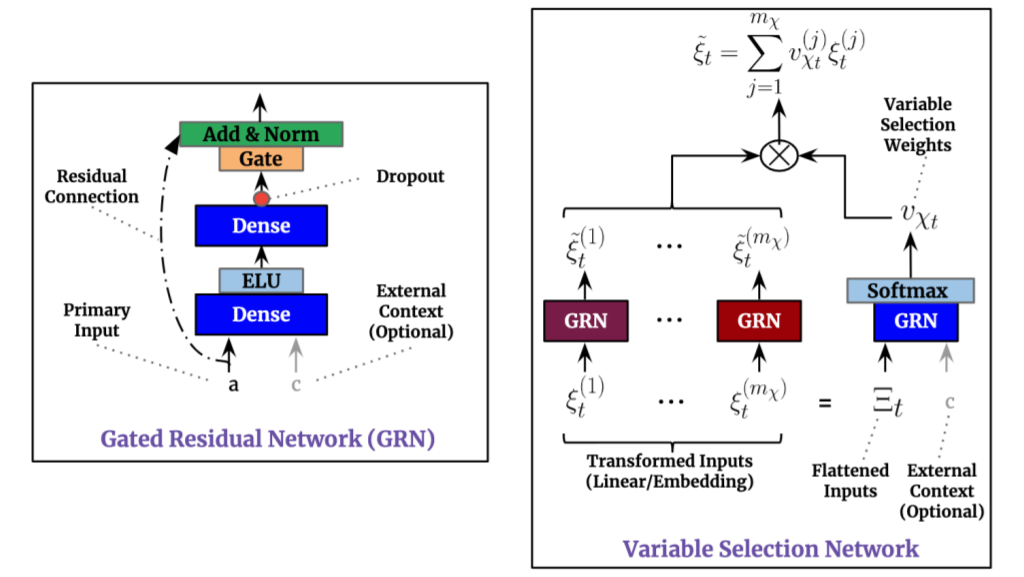

Implementation is taken from [here](https://keras.io/examples/structured_data/classification_with_grn_and_vsn/)

In [ ]:
from tensorflow.keras import layers
import tensorflow as tf

def create_model_inputs():
    inputs = {}
    for feature_name in FEATURES:
        inputs[feature_name] = layers.Input(
            name=feature_name, shape=(), dtype=tf.float32
        )
    return inputs

def encode_inputs(inputs, encoding_size):
    encoded_features = []
    for i in range(inputs.shape[1]):
        encoded_feature = tf.expand_dims(inputs[:, i], -1)
        encoded_feature = layers.Dense(units=encoding_size)(encoded_feature)
        encoded_features.append(encoded_feature)
    return encoded_features

class GatedLinearUnit(layers.Layer):
    def __init__(self, units):
        super(GatedLinearUnit, self).__init__()
        self.linear = layers.Dense(units)
        self.sigmoid = layers.Dense(units, activation="sigmoid")

    def call(self, inputs):
        return self.linear(inputs) * self.sigmoid(inputs)
    
class GatedResidualNetwork(layers.Layer):
    def __init__(self, units, dropout_rate=0.15):
        super(GatedResidualNetwork, self).__init__()
        self.units = units
        self.elu_dense = layers.Dense(units, activation="swish")
        self.linear_dense = layers.Dense(units)
        self.dropout = layers.Dropout(dropout_rate)
        self.gated_linear_unit = GatedLinearUnit(units)
        self.layer_norm = layers.LayerNormalization()
        self.project = layers.Dense(units)

    def call(self, inputs):
        x = self.elu_dense(inputs)
        x = self.linear_dense(x)
        x = self.dropout(x)
        if inputs.shape[-1] != self.units:
            inputs = self.project(inputs)
        x = inputs + self.gated_linear_unit(x)
        x = self.layer_norm(x)
        return x

class VariableSelection(layers.Layer):
    def __init__(self, num_features, units, dropout_rate):
        super(VariableSelection, self).__init__()
        self.grns = list()
        # Create a GRN for each feature independently
        for idx in range(num_features):
            grn = GatedResidualNetwork(units, dropout_rate)
            self.grns.append(grn)
        # Create a GRN for the concatenation of all the features
        self.grn_concat = GatedResidualNetwork(units, dropout_rate)
        self.softmax = layers.Dense(units=num_features, activation="softmax")

    def call(self, inputs):
        v = layers.concatenate(inputs)
        v = self.grn_concat(v)
        v = tf.expand_dims(self.softmax(v), axis=-1)

        x = []
        for idx, input in enumerate(inputs):
            x.append(self.grns[idx](input))
        x = tf.stack(x, axis=1)

        outputs = tf.squeeze(tf.matmul(v, x, transpose_a=True), axis=1)
        return outputs
    
def create_model(encoding_size, dropout_rate=0.15):
    inputs = layers.Input(len(FEATURES))
    feature_list = encode_inputs(inputs, encoding_size)
    num_features = len(feature_list)

    features = VariableSelection(num_features, encoding_size, dropout_rate)(
        feature_list
    )

    outputs = layers.Dense(units=1, activation="sigmoid")(features)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
from collections import defaultdict
import tensorflow as tf

oof_df = defaultdict(lambda : [])
test_df = defaultdict(lambda : np.zeros((X_test.shape[0])))

N_FOLDS = 5
ENCODING_SIZE = 32
EPOCHS = 500
VERBOSE = 1
start = time.time()

skfolds = model_selection.StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

for fold, (t, v) in enumerate(skfolds.split(X, Y)):
    x_train, x_val = X[t], X[v]
    y_train, y_val = Y[t], Y[v]
    
    oof_df[TARGET].extend(y_val)
    print(f"\n{'-'*15} FOLD-{fold} {'-'*15}")
    
    tic = time.time()
    
#     clf = tf.keras.Sequential([
#         tf.keras.layers.Input(len(FEATURES)),
#         tf.keras.layers.Dense(256, activation='swish'),
#         tf.keras.layers.Dropout(0.3),
#         tf.keras.layers.Dense(128, activation='swish'),
#         tf.keras.layers.Dropout(0.2),
#         tf.keras.layers.Dense(64, activation='swish'),
#         tf.keras.layers.Dropout(0.2),
#         tf.keras.layers.Dense(32, activation='swish'),
#         tf.keras.layers.Dropout(0.2),
#         tf.keras.layers.Dense(16, activation='swish'),
#         tf.keras.layers.Dropout(0.2),
#         tf.keras.layers.Dense(1, activation='sigmoid'),
#     ])
    clf = create_model(ENCODING_SIZE)
    
    clf.compile(loss='binary_crossentropy', 
                optimizer='adam', 
                metrics=[tf.keras.metrics.AUC(name='auc'), 'acc'])
    
    lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.25, 
                               patience=4, verbose=VERBOSE)

    es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, 
                       verbose=VERBOSE, mode="min", 
                       restore_best_weights=True)
    
    clf.fit(x_train, y_train, 
            epochs=EPOCHS, batch_size=2048,
            validation_data=(x_val, y_val),
            validation_batch_size=len(y_val),
            callbacks=[es, lr],
            shuffle=True,
            verbose=VERBOSE)
    
    preds = np.squeeze(clf.predict(x_val, batch_size=len(y_val)))
    oof_df[f'nn'].extend(preds)
    test_df[f'nn'] += (np.squeeze(clf.predict(X_test, batch_size=2048) / N_FOLDS))

    score = metrics.roc_auc_score(y_val, preds)
    print(f"MODEL: nn\tSCORE: {score}\tTIME: {format_time(time.time()-tic)}")

    del clf
    gc.collect()
        
    del x_train, x_val, y_train, y_val
    gc.collect()
        
oof_df = pd.DataFrame(oof_df)
test_df = pd.DataFrame(test_df)

print()
print(f'TOTAL TIME: {format_time(time.time() - start)}')

In [ ]:
score = metrics.roc_auc_score(oof_df[TARGET], oof_df['nn'])
print(f'Overall ROC AUC of: {score}')

## Submission

In [ ]:
submission = pd.read_csv('../input/tabular-playground-series-nov-2021/sample_submission.csv')
submission[TARGET] = test_df['nn']
submission.to_csv('submission.csv', index=False)

submission.head()